In [218]:
import numpy as np
import pandas as pd

import scipy
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

from pathlib import Path
data_dir = Path('.')

import os
os.listdir(data_dir)

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_dark"

# enable the png render for viewing graphs in the github repo
#pio.renderers.default = "notebook_connected"
pio.renderers.default = "png"

from plotly.subplots import make_subplots

#from scipy.optimize import curve_fit


### Equations from: https://www.idmod.org/docs/hiv/model-seir.html

In [219]:
# Susceptible equation
def dS_dt(S, I, beta, N):
    return -(beta / N) * I * S

# Exposed equation
def dE_dt(S, I, N, E, beta, sigma):
    return (beta / N) * I * S - sigma * E

# Infected equation
def dI_dt(E, I, sigma, gamma):
    return sigma * E - gamma * I

# Recovered/Remove/deceased equation
def dR_dt(I, gamma):
    return gamma * I

def SEIR_model(t, y, N, R, sigma, gamma):
    
    if callable(R):
        beta = R(t)
    else:
        beta = R
        
    S, E, I, R = y
    
    S_out = dS_dt(S, I, beta, N)
    E_out = dE_dt(S, I, N, E, beta, sigma)
    I_out = dI_dt(E, I, sigma, gamma)
    R_out = dR_dt(I, gamma)
    
    return S_out, E_out, I_out, R_out

### Model without intervention

In [220]:
# Total population, N.
N = 1300000000
# Initial number of infected, recovered and exposed individuals, I0, R0 and E0.
I0, R0, E0 = 1, 0, 0
# Everyone else, i.e. susceptible population.
S0 = N - I0 - R0 - E0
# Contact rate, beta = Reproductive_number*gamma, and mean recovery rate gamma (in 1/days), incubation rate sigma (in 1/days) .
beta, gamma, sigma = 3.954/2.9, 1./2.9, 1./5.2

t = np.arange(max_days)

y0 = S0, E0, I0, R0
params = beta, sigma, gamma

#Solve the differencial quations
sol = solve_ivp(SEIR_model, [0, max_days], [S0, E0, I0, R0], args=(N, beta, sigma, gamma), t_eval=np.arange(max_days))
S, E, I, R = sol.y

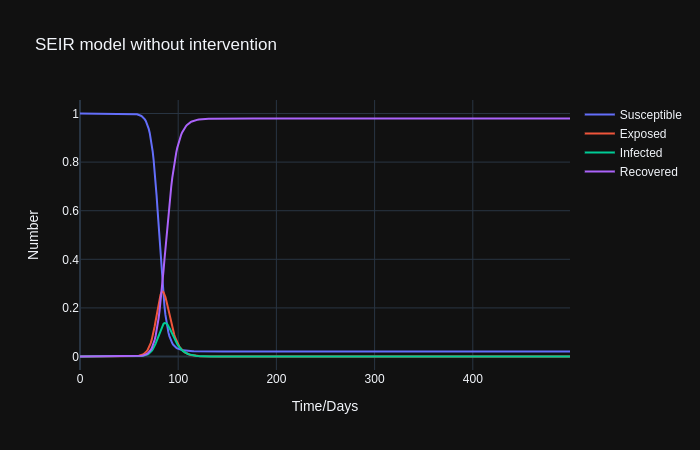

In [221]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=S/N,
                    mode='lines',
                    name='Susceptible'))
fig.add_trace(go.Scatter(x=t, y=E/N,
                    mode='lines',
                    name='Exposed'))
fig.add_trace(go.Scatter(x=t, y=I/N,
                    mode='lines',
                    name='Infected'))
fig.add_trace(go.Scatter(x=t, y=R/N,
                    mode='lines',
                    name='Recovered'))
fig.update_layout(
    title="SEIR model without intervention",
    xaxis_title="Time/Days",
    yaxis_title="Number",
)
fig.show()
    


### Model with intervention

Assuming a total lockdown period of 21 days.

In [222]:
lockdown_day = 70
lockdown_lifted = lockdown_day + 21
max_days = 500

def time_varying_reproduction(t):
    if t > lockdown_day and t < lockdown_lifted:
        return 0.5/2.9
    else:
        return 3.954/2.9

t = np.arange(max_days)

y0 = S0, E0, I0, R0

sol = solve_ivp(SEIR_model, [0, max_days], [S0, E0, I0, R0], args=(N, time_varying_reproduction, sigma, gamma), t_eval=np.arange(max_days))

S_new, E_new, I_new, R_new = sol.y

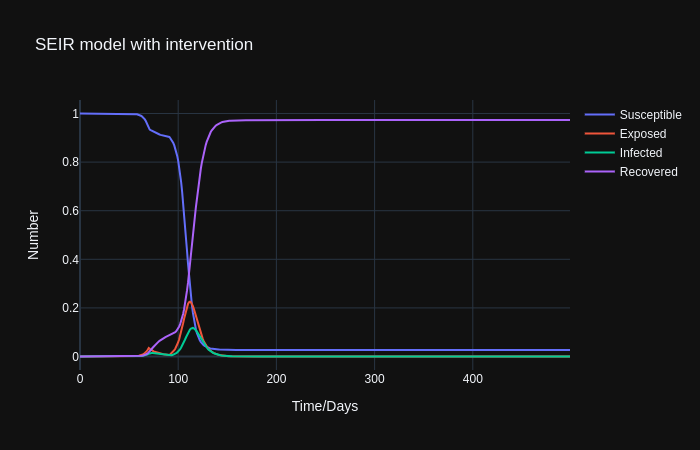

In [223]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=S_new/N,
                    mode='lines',
                    name='Susceptible'))
fig.add_trace(go.Scatter(x=t, y=E_new/N,
                    mode='lines',
                    name='Exposed'))
fig.add_trace(go.Scatter(x=t, y=I_new/N,
                    mode='lines',
                    name='Infected'))
fig.add_trace(go.Scatter(x=t, y=R_new/N,
                    mode='lines',
                    name='Recovered'))
fig.update_layout(
    title="SEIR model with intervention",
    xaxis_title="Time/Days",
    yaxis_title="Number",
)
fig.show()

#### Intervention with exponential hill decay

In [224]:
max_days = 500

# https://github.com/SwissTPH/openmalaria/wiki/ModelDecayFunctions   
# Hill decay. Initial values: R_0=2.2, k=2, L=50
R_0 = 2.2
k = 2
L = 50
def time_varying_reproduction(t): 
        return R_0 / (1 + (t/L)**k)

t = np.arange(max_days)

y0 = S0, E0, I0, R0

sol = solve_ivp(SEIR_model, [0, max_days], [S0, E0, I0, R0], args=(N, time_varying_reproduction, sigma, gamma), t_eval=np.arange(max_days))

S_new, E_new, I_new, R_new = sol.y

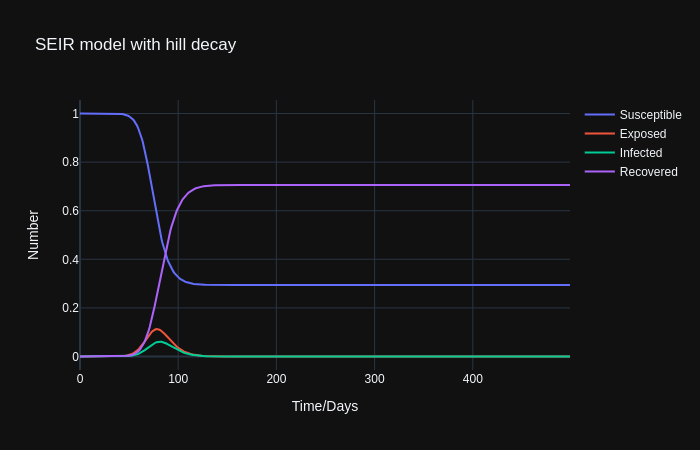

In [226]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=t, y=S_new/N,
                    mode='lines',
                    name='Susceptible'))
fig.add_trace(go.Scatter(x=t, y=E_new/N,
                    mode='lines',
                    name='Exposed'))
fig.add_trace(go.Scatter(x=t, y=I_new/N,
                    mode='lines',
                    name='Infected'))
fig.add_trace(go.Scatter(x=t, y=R_new/N,
                    mode='lines',
                    name='Recovered'))
fig.update_layout(
    title="SEIR model with hill decay",
    xaxis_title="Time/Days",
    yaxis_title="Number",
)
fig.show()